In [2]:
import pandas as pd
data_new = pd.read_csv('data/graph_extractor.csv')

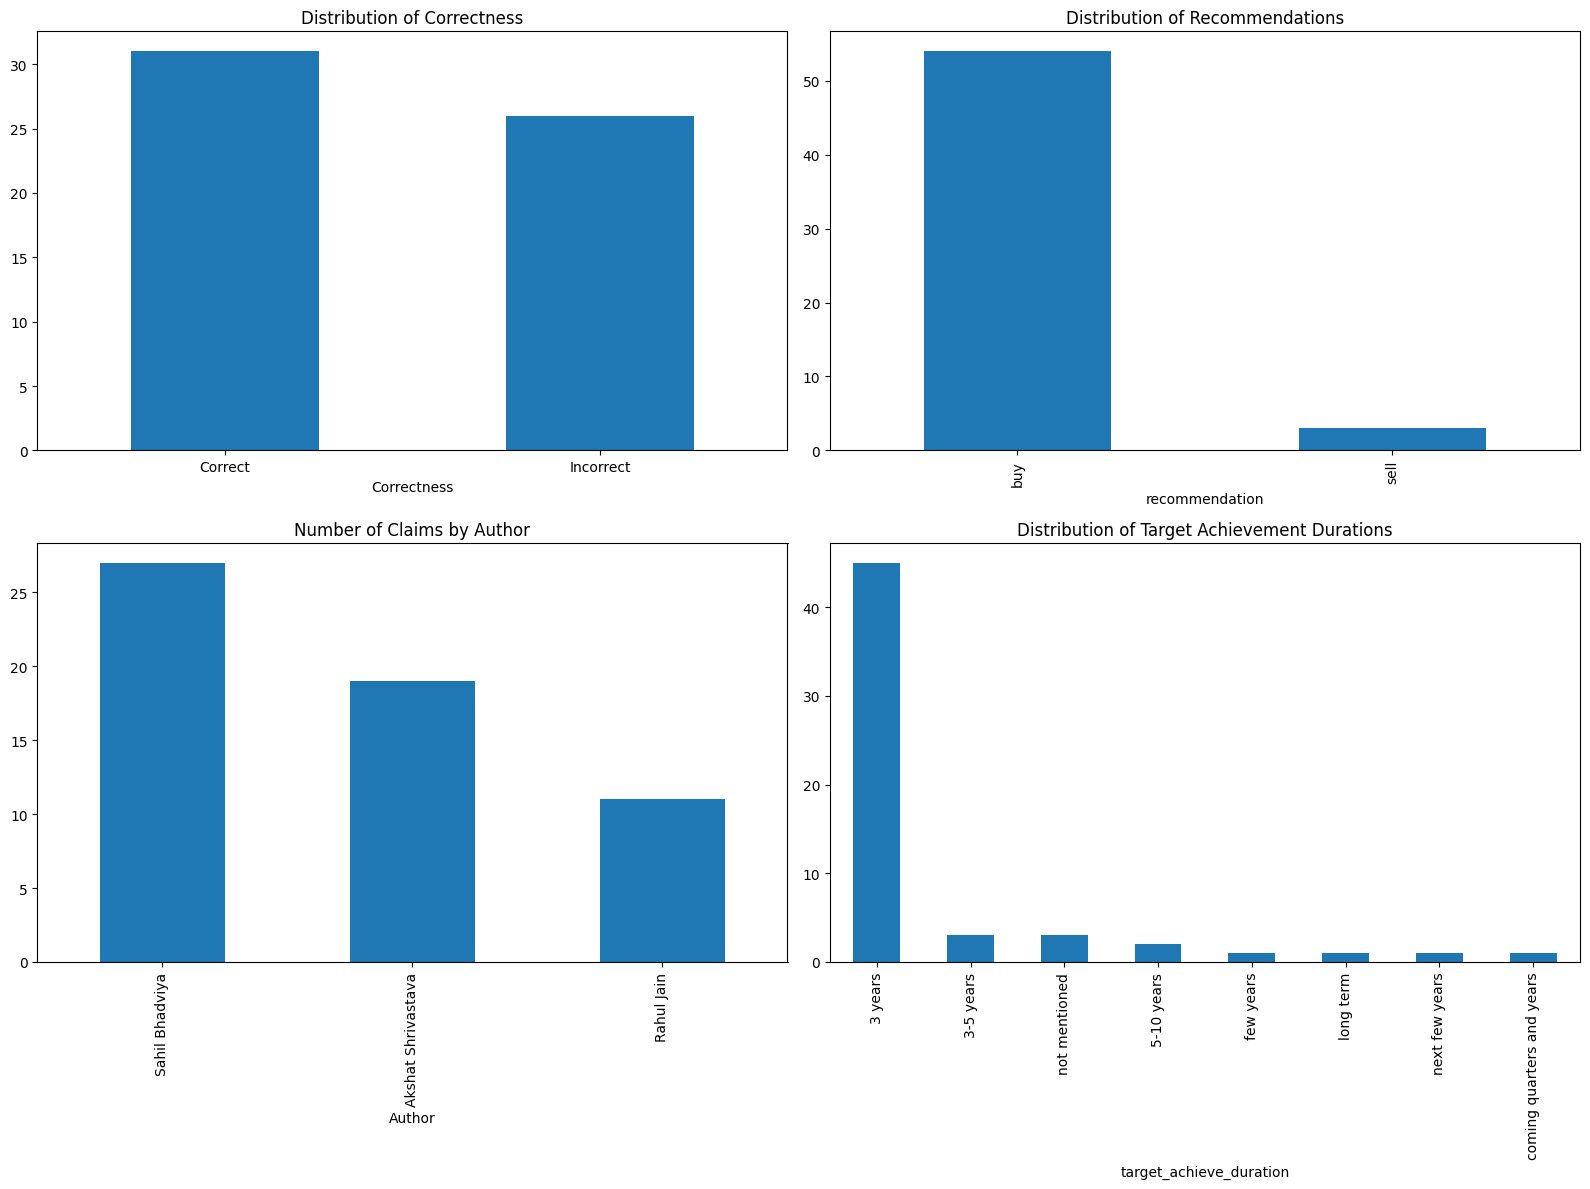

In [3]:
import matplotlib.pyplot as plt

# Set up the plots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Plot distribution of 'Correctness'
data_new['Correctness'].value_counts().plot(kind='bar', ax=ax[0][0], title='Distribution of Correctness')
ax[0][0].set_xticklabels(['Correct', 'Incorrect'], rotation=0)

# Plot distribution of recommendations
data_new['recommendation'].value_counts().plot(kind='bar', ax=ax[0][1], title='Distribution of Recommendations')

# Plot number of claims made by each author
data_new['Author'].value_counts().plot(kind='bar', ax=ax[1][0], title='Number of Claims by Author')

# Plot distribution of target achievement durations
data_new['target_achieve_duration'].value_counts().plot(kind='bar', ax=ax[1][1], title='Distribution of Target Achievement Durations')

plt.tight_layout()
plt.show()


In [4]:
# Convert 'Publish Date' to datetime format for further calculations
data_new['Publish Date'] = pd.to_datetime(data_new['Publish Date'], dayfirst=True)

# 1. Author's Past Accuracy
# Calculate the historical accuracy of each YouTuber
author_accuracy = data_new.groupby('Author')['Correctness'].mean().reset_index()
author_accuracy.columns = ['Author', 'Author_Past_Accuracy']

# 2. Author's Experience
# Calculate the total number of claims made by the author
author_experience = data_new['Author'].value_counts().reset_index()
author_experience.columns = ['Author', 'Author_Experience']

# 3. Stock-specific Accuracy
# Calculate the accuracy of the YouTuber's past claims specific to a particular stock
stock_specific_accuracy = data_new.groupby(['Author', 'ticker'])['Correctness'].mean().reset_index()
stock_specific_accuracy.columns = ['Author', 'ticker', 'Stock_Specific_Accuracy']

# 4. Time Decay
# Assign weights to past predictions based on how recent they are
# We'll use an exponential decay with a half-life of 180 days (approximately 6 months)
current_date = data_new['Publish Date'].max()
data_new['Time_Decay'] = (current_date - data_new['Publish Date']).dt.days
data_new['Time_Decay'] = 0.5 ** (data_new['Time_Decay'] / 180)

# Merge the new features into the main dataset
data_new = data_new.merge(author_accuracy, on='Author', how='left')
data_new = data_new.merge(author_experience, on='Author', how='left')
data_new = data_new.merge(stock_specific_accuracy, on=['Author', 'ticker'], how='left')

data_new.head()


/var/folders/35/mj3g4g9952j00j9pwxnzf0fr0000gq/T/ipykernel_90982/4139374074.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_new['Publish Date'] = pd.to_datetime(data_new['Publish Date'], dayfirst=True)


,ticker,recommendation,target_achieve_duration,Author,Publish Date,Correctness,Time_Decay,Author_Past_Accuracy,Author_Experience,Stock_Specific_Accuracy
0,gtbl,buy,3 years,Rahul Jain,2023-07-30,1,0.962224,0.545455,11,1.0
1,sbin,buy,3 years,Rahul Jain,2023-06-18,1,0.818532,0.545455,11,1.0
2,itc,buy,3 years,Rahul Jain,2023-06-18,0,0.818532,0.545455,11,0.0
3,tcs,buy,3 years,Rahul Jain,2023-06-18,0,0.818532,0.545455,11,0.0
4,TCS,buy,3 years,Rahul Jain,2023-08-09,1,1.000000,0.545455,11,1.0


In [5]:
import networkx as nx

# Initialize a directed graph
G = nx.DiGraph()

# Add YouTuber nodes to the graph
for author, attributes in data_new[['Author', 'Author_Past_Accuracy', 'Author_Experience']].drop_duplicates().iterrows():
    G.add_node(attributes['Author'], node_type="YouTuber", past_accuracy=attributes['Author_Past_Accuracy'], experience=attributes['Author_Experience'])

# Add Stock nodes to the graph
for ticker in data_new['ticker'].unique():
    G.add_node(ticker, node_type="Stock")

# Add edges between YouTubers and Stocks
for _, row in data_new.iterrows():
    G.add_edge(row['Author'], row['ticker'], recommendation=row['recommendation'], datetime=row['Publish Date'], weight=row['Correctness'])

# Check the graph construction
list(G.nodes(data=True))[:5], list(G.edges(data=True))[:5]


([('Rahul Jain',
   {'node_type': 'YouTuber',
    'past_accuracy': 0.5454545454545454,
    'experience': 11}),
  ('Akshat Shrivastava',
   {'node_type': 'YouTuber',
    'past_accuracy': 0.5263157894736842,
    'experience': 19}),
  ('Sahil Bhadviya',
   {'node_type': 'YouTuber',
    'past_accuracy': 0.5555555555555556,
    'experience': 27}),
  ('gtbl', {'node_type': 'Stock'}),
  ('sbin', {'node_type': 'Stock'})],
 [('Rahul Jain',
   'gtbl',
   {'recommendation': 'buy',
    'datetime': Timestamp('2023-07-30 00:00:00'),
    'weight': 1}),
  ('Rahul Jain',
   'sbin',
   {'recommendation': 'buy',
    'datetime': Timestamp('2023-06-18 00:00:00'),
    'weight': 1}),
  ('Rahul Jain',
   'itc',
   {'recommendation': 'buy',
    'datetime': Timestamp('2023-06-18 00:00:00'),
    'weight': 0}),
  ('Rahul Jain',
   'tcs',
   {'recommendation': 'buy',
    'datetime': Timestamp('2023-06-18 00:00:00'),
    'weight': 0}),
  ('Rahul Jain',
   'TCS',
   {'recommendation': 'buy',
    'datetime': Timestam

[]

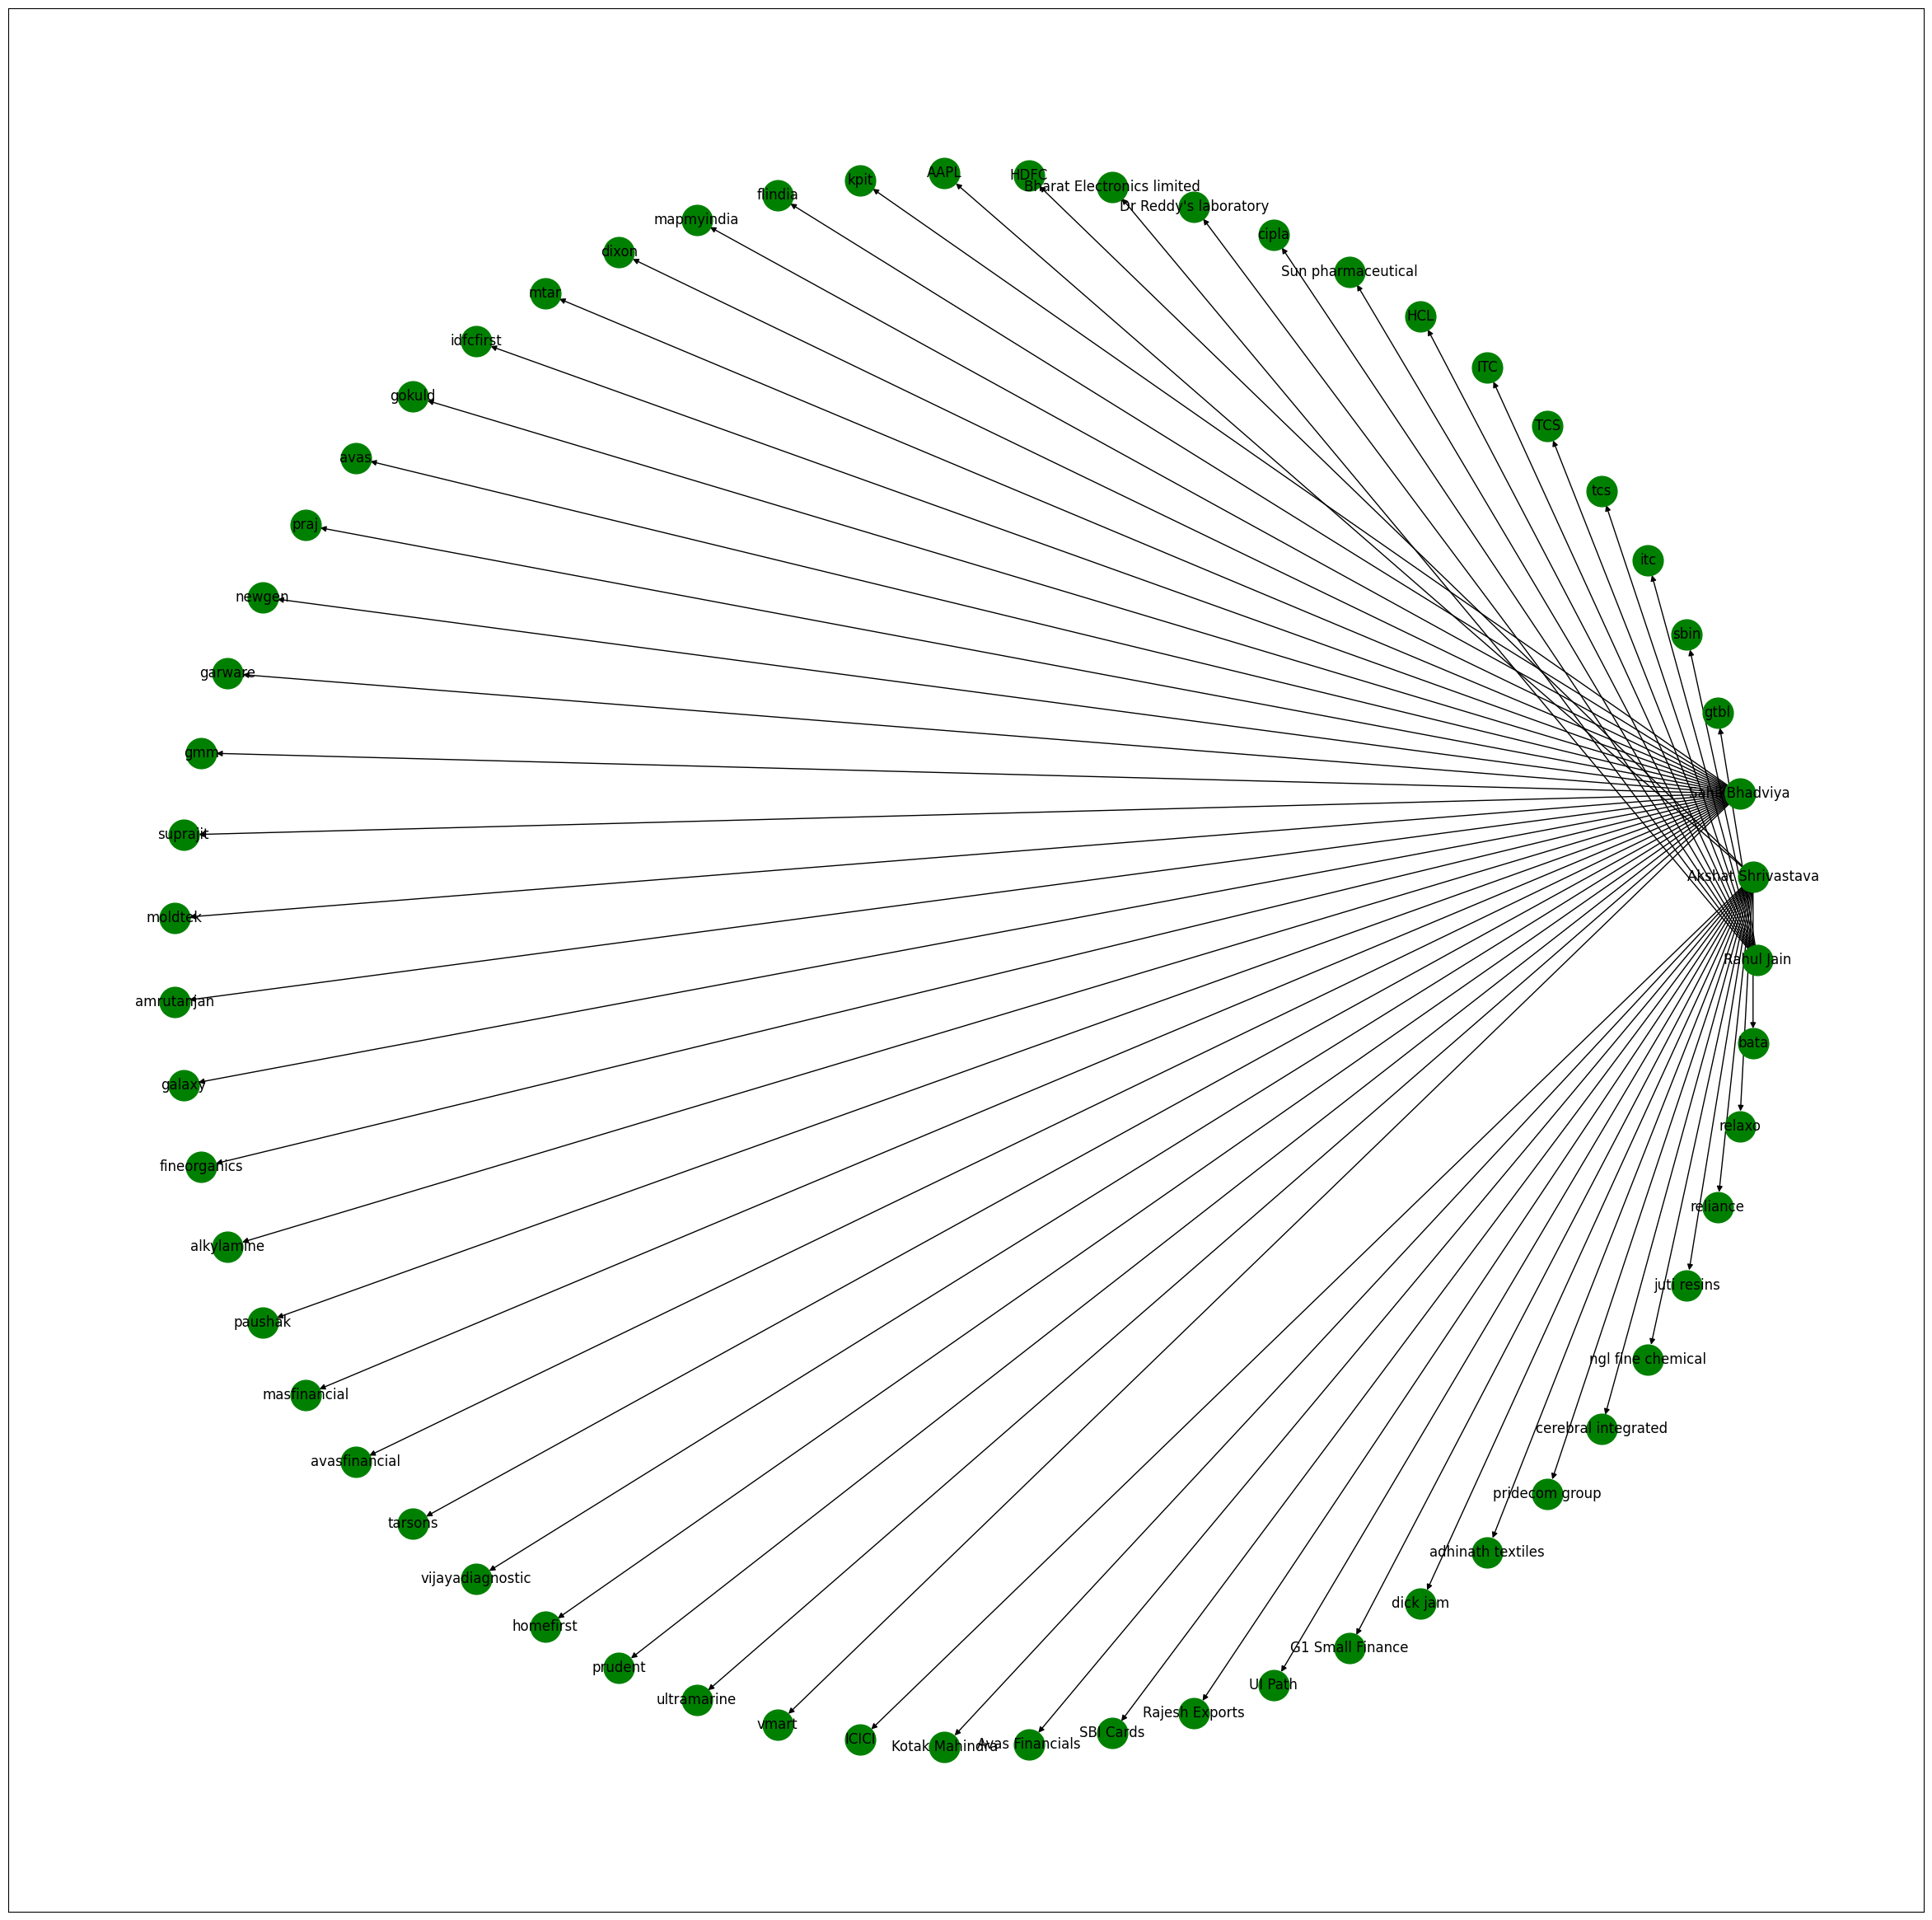

In [15]:
plt.figure(figsize=(30,30)) 
nx.draw_networkx(G,
    pos = nx.kamada_kawai_layout(G), 
    node_size = 700,
    node_color = "green",
    #width = [G.edges[e]['correctness'] for e in G.edges],
    with_labels = True)
plt.plot()

In [6]:
# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Recompute scores for traditional link prediction methods

# Common Neighbors
common_neighbors = [(e[0], e[1], len(list(nx.common_neighbors(G_undirected, e[0], e[1])))) for e in nx.non_edges(G_undirected)]

# Jaccard Coefficient
jaccard_coefficient = list(nx.jaccard_coefficient(G_undirected))

# Adamic/Adar Index
adamic_adar_index = list(nx.adamic_adar_index(G_undirected))

# Resource Allocation Index
resource_allocation_index = list(nx.resource_allocation_index(G_undirected))

# Convert scores to DataFrames for easier analysis
df_common_neighbors = pd.DataFrame(common_neighbors, columns=["YouTuber", "Stock", "Common_Neighbors"])
df_jaccard = pd.DataFrame(jaccard_coefficient, columns=["YouTuber", "Stock", "Jaccard_Coefficient"])
df_adamic_adar = pd.DataFrame(adamic_adar_index, columns=["YouTuber", "Stock", "Adamic_Adar_Index"])
df_resource_allocation = pd.DataFrame(resource_allocation_index, columns=["YouTuber", "Stock", "Resource_Allocation_Index"])

# Merge the scores into one DataFrame
df_scores = df_common_neighbors.merge(df_jaccard, on=["YouTuber", "Stock"]).merge(df_adamic_adar, on=["YouTuber", "Stock"]).merge(df_resource_allocation, on=["YouTuber", "Stock"])

df_scores.head()


,YouTuber,Stock,Common_Neighbors,Jaccard_Coefficient,Adamic_Adar_Index,Resource_Allocation_Index
0,Bharat Electronics limited,cipla,1,1.0,0.417032,0.090909
1,Bharat Electronics limited,amrutanjan,0,0.0,0.000000,0.000000
2,Bharat Electronics limited,AAPL,0,0.0,0.000000,0.000000
3,Bharat Electronics limited,Dr Reddy's laboratory,1,1.0,0.417032,0.090909
4,Bharat Electronics limited,galaxy,0,0.0,0.000000,0.000000


In [12]:
df_scores

,YouTuber,Stock,Common_Neighbors,Jaccard_Coefficient,Adamic_Adar_Index,Resource_Allocation_Index
0,Bharat Electronics limited,cipla,1,1.0,0.417032,0.090909
1,Bharat Electronics limited,amrutanjan,0,0.0,0.000000,0.000000
2,Bharat Electronics limited,AAPL,0,0.0,0.000000,0.000000
3,Bharat Electronics limited,Dr Reddy's laboratory,1,1.0,0.417032,0.090909
4,Bharat Electronics limited,galaxy,0,0.0,0.000000,0.000000
...,...,...,...,...,...,...
1650,newgen,gtbl,0,0.0,0.000000,0.000000
1651,newgen,HDFC,0,0.0,0.000000,0.000000
1652,paushak,gtbl,0,0.0,0.000000,0.000000
1653,paushak,HDFC,0,0.0,0.000000,0.000000


In [17]:
def refined_infer_link_score(youtuber, stock, recommendation, graph):
    """
    Predict the credibility score of a recommendation between a YouTuber and a stock using traditional link prediction methods.
    Incorporate the recommendation type (buy/sell) into the scoring.
    """
    # Check if the nodes exist in the graph and if the recommendation is valid
    if youtuber not in graph.nodes() or stock not in graph.nodes():
        raise ValueError("Either the YouTuber or the stock is not present in the graph.")
    if recommendation not in ['buy', 'sell']:
        raise ValueError("Invalid recommendation type. Accepted values are 'buy' or 'sell'.")
    
    # Filter edges based on the recommendation type
    subgraph = nx.subgraph_view(graph, filter_edge=lambda u, v: graph[u][v]['recommendation'] == recommendation)
    
    # Calculate scores
    common_neighbors_score = len(list(nx.common_neighbors(subgraph, youtuber, stock)))
    jaccard_score = list(nx.jaccard_coefficient(subgraph, [(youtuber, stock)]))[0][2]
    adamic_adar_score = list(nx.adamic_adar_index(subgraph, [(youtuber, stock)]))[0][2]
    resource_allocation_score = list(nx.resource_allocation_index(subgraph, [(youtuber, stock)]))[0][2]
    
    # Average the scores to get a composite score
    composite_score = (common_neighbors_score + jaccard_score + adamic_adar_score + resource_allocation_score) / 4.0
    
    return {
        "Common Neighbors": common_neighbors_score,
        "Jaccard Coefficient": jaccard_score,
        "Adamic/Adar Index": adamic_adar_score,
        "Resource Allocation Index": resource_allocation_score,
        "Composite Score": composite_score
    }

# Test the refined inference function with a sample YouTuber, stock, and recommendation
sample_recommendation = "sell"
refined_scores = refined_infer_link_score("Rahul Jain", "sbin", sample_recommendation, G_undirected)
refined_scores


{'Common Neighbors': 0,
 'Jaccard Coefficient': 0,
 'Adamic/Adar Index': 0,
 'Resource Allocation Index': 0,
 'Composite Score': 0.0}